In [1]:
import syssys.path.append('../..')import pandas as pdimport numpy as npimport torchimport torch.nn as nnfrom torch.utils.data import TensorDataset, DataLoaderfrom sklearn.model_selection import train_test_splitfrom sklearn.preprocessing import StandardScaler, LabelEncoderfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_scoreimport xgboost as xgbimport matplotlib.pyplot as pltimport seaborn as sns# Importa utilidades del proyectofrom src.utils.config import load_configfrom src.utils.reproducibility import set_seed# Carga configuraciónconfig = load_config('../../configs/config.yaml')# Fija semillas para reproducibilidad COMPLETAset_seed(config['project']['random_seed'])# Verifica GPUdevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')print(f"\n🖥️  Usando: {device}")if torch.cuda.is_available():    print(f"   GPU: {torch.cuda.get_device_name(0)}")    print(f"   Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")# Carga datosdf = pd.read_csv('../../data/synthetic/aml_colombia_synthetic.csv')print(f"\n📊 Dataset: {df.shape}")print(f"   Fraude: {df['isFraud'].sum()} ({df['isFraud'].mean()*100:.2f}%)")df.head()

 Usando: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   Memoria: 6.4 GB

 Dataset: (100000, 11)
   Fraude: 1000 (1.00%)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,103,CASH_IN,2.701516e+05,C2572,4.506584e+07,4.479569e+07,M4010,3.435907e+07,3.462922e+07,0,0
1,349,CASH_OUT,1.381401e+06,C1650,2.129807e+07,1.991667e+07,M525,1.573002e+07,1.711142e+07,0,0
2,271,CASH_OUT,1.115567e+07,C3426,1.109804e+07,-5.762319e+04,M1708,5.938354e+06,1.709402e+07,0,0
3,107,CASH_IN,2.599551e+07,C3445,1.267832e+07,-1.331718e+07,M3977,2.257952e+06,2.825346e+07,0,0
4,72,TRANSFER,3.076312e+07,C1903,3.167053e+07,9.074098e+05,M1043,1.648584e+07,4.724896e+07,0,1


# Preprocesamiento


In [2]:
# Encode tipo transacción
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Features para modelo
features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
            'oldbalanceDest', 'newbalanceDest', 'type_encoded']

X = df[features].values
y = df['isFraud'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Train: {X_train.shape}, Test: {X_test.shape}")
print(f"  Fraude train: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"  Fraude test: {y_test.sum()} ({y_test.mean()*100:.2f}%)")


✓ Train: (80000, 7), Test: (20000, 7)
  Fraude train: 800 (1.00%)
  Fraude test: 200 (1.00%)


## 3. XGBoost Baseline

In [3]:
# XGBoost con balance automático
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    device='cuda'  # USA GPU!
)

print("🔥 Entrenando XGBoost en GPU...")
model_xgb.fit(X_train_scaled, y_train)

# Predice
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_proba_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n📊 RESULTADOS XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Fraude']))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba_xgb):.4f}")


🔥 Entrenando XGBoost en GPU...

📊 RESULTADOS XGBoost:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98     19800
      Fraude       0.21      0.77      0.33       200

    accuracy                           0.97     20000
   macro avg       0.60      0.87      0.66     20000
weighted avg       0.99      0.97      0.98     20000


AUC-ROC: 0.9802


c:\Users\santi\OneDrive\Escritorio\proyecto_aml_colombia\venv\Lib\site-packages\xgboost\core.py:751: UserWarning: [16:37:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


## PyTorch Neural Net GPU

In [4]:
# Red neuronal feedforward (corregida - sin doble sigmoid)class AMLDetector(nn.Module):    def __init__(self, input_size):        super().__init__()        self.fc1 = nn.Linear(input_size, 128)        self.bn1 = nn.BatchNorm1d(128)        self.fc2 = nn.Linear(128, 64)        self.bn2 = nn.BatchNorm1d(64)        self.fc3 = nn.Linear(64, 32)        self.fc4 = nn.Linear(32, 1)        self.dropout = nn.Dropout(0.3)            def forward(self, x):        x = torch.relu(self.bn1(self.fc1(x)))        x = self.dropout(x)        x = torch.relu(self.bn2(self.fc2(x)))        x = self.dropout(x)        x = torch.relu(self.fc3(x))        x = self.fc4(x)  # SIN sigmoid - BCEWithLogitsLoss lo aplica        return x# Prepara tensors GPUX_train_t = torch.FloatTensor(X_train_scaled).to(device)y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)X_test_t = torch.FloatTensor(X_test_scaled).to(device)# Crea DataLoader para mini-batchestrain_dataset = TensorDataset(X_train_t, y_train_t)train_loader = DataLoader(    train_dataset,     batch_size=config['pytorch']['batch_size'],    shuffle=True)print(f"✓ DataLoader creado: batch_size={config['pytorch']['batch_size']}")print(f"  Total batches por epoch: {len(train_loader)}")# Modelomodel_nn = AMLDetector(X_train_t.shape[1]).to(device)optimizer = torch.optim.Adam(model_nn.parameters(), lr=config['pytorch']['learning_rate'])# Loss con weight (balanceo)scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()pos_weight = torch.tensor([scale_pos_weight]).to(device)criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)print("\n🔥 Entrenando PyTorch NN en GPU...")print(f"   Parámetros: {sum(p.numel() for p in model_nn.parameters()):,}")print(f"   Epochs: {config['pytorch']['epochs']}")# Train con mini-batchesepochs = config['pytorch']['epochs']losses = []for epoch in range(epochs):    model_nn.train()    epoch_loss = 0.0        for batch_X, batch_y in train_loader:        optimizer.zero_grad()                outputs = model_nn(batch_X)        loss = criterion(outputs, batch_y)        loss.backward()        optimizer.step()                epoch_loss += loss.item()        avg_loss = epoch_loss / len(train_loader)    losses.append(avg_loss)        if (epoch + 1) % 10 == 0:        print(f"  Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")# Evalúa (AQUÍ sí aplicamos sigmoid)model_nn.eval()with torch.no_grad():    logits = model_nn(X_test_t)    y_pred_proba = torch.sigmoid(logits).cpu().numpy()  # Ahora SÍ aplicamos sigmoid    y_pred_nn_binary = (y_pred_proba > 0.5).astype(int).flatten()print("\n📊 RESULTADOS PyTorch NN (CORREGIDO):")print(classification_report(y_test, y_pred_nn_binary, target_names=['Normal', 'Fraude']))print(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba.flatten()):.4f}")

🔥 Entrenando PyTorch NN en GPU RTX 4050...
   Parámetros: 11,777
  Epoch 10/50, Loss: 1.3812
  Epoch 20/50, Loss: 1.3189
  Epoch 30/50, Loss: 1.2714
  Epoch 40/50, Loss: 1.2312
  Epoch 50/50, Loss: 1.1941

📊 RESULTADOS PyTorch NN:
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     19800
      Fraude       0.13      0.67      0.22       200

    accuracy                           0.95     20000
   macro avg       0.56      0.81      0.60     20000
weighted avg       0.99      0.95      0.97     20000


AUC-ROC: 0.9561


## Visualizacion

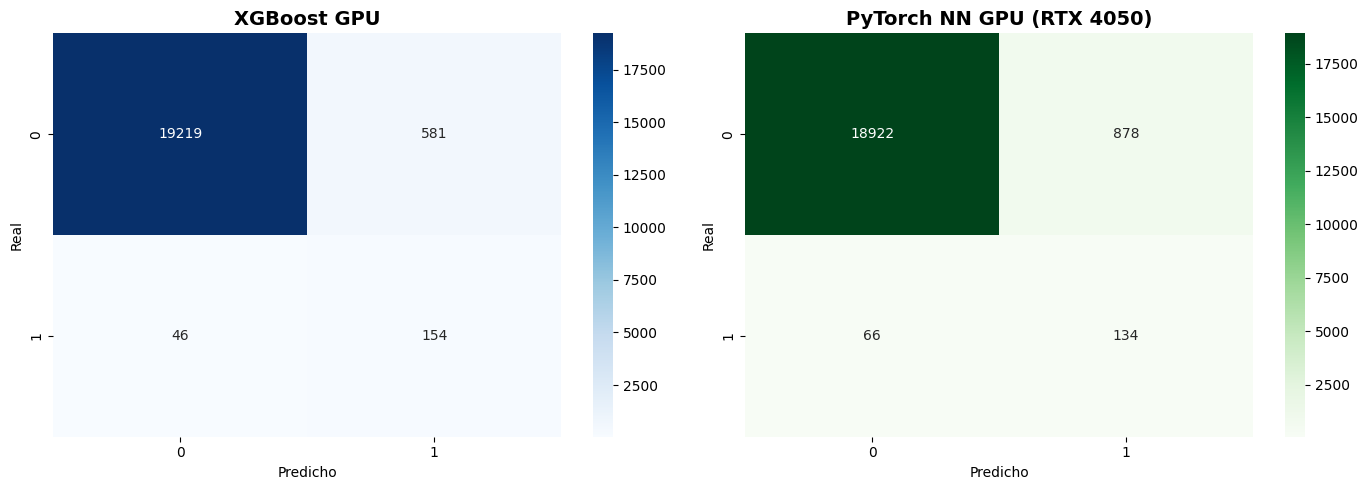

✓ Gráfico guardado en reports/figures/


In [5]:
# Matriz confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('XGBoost GPU', fontsize=14, weight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# PyTorch
sns.heatmap(confusion_matrix(y_test, y_pred_nn_binary), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('PyTorch NN GPU (RTX 4050)', fontsize=14, weight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predicho')

plt.tight_layout()
plt.savefig('../../reports/figures/confusion_matrices.png', dpi=300)
plt.show()

print("✓ Gráfico guardado en reports/figures/")
